# Simulación de Moléculas usando VQE

En este tutorial, presentamos el Solucionador Propio Cuántico Variacional (Variational Quantum Eigensolver, VQE), motivamos su uso, explicamos la teoría necesaria y demostramos su implementación para encontrar la energía del estado fundamental de las moléculas.

## Introducción

En muchas aplicaciones es importante encontrar el valor propio mínimo de una matriz. Por ejemplo, en química, el valor propio mínimo de una matriz Hermitiana que caracteriza a la molécula es la energía del estado fundamental de ese sistema. En el futuro, el algoritmo de estimación de fase cuántica se puede usar para encontrar el valor propio mínimo. Sin embargo, su implementación en problemas útiles requiere profundidades de circuito que excedan los límites del hardware disponible en la era NISQ. Así, en 2014, Peruzzo *et al.* propusieron VQE para estimar la energía del estado fundamental de una molécula utilizando circuitos mucho menos profundos [1].

Expresado formalmente, dada una matriz Hermitiana $H$ con un valor propio mínimo desconocido $\lambda_{\text{min}}$, asociado con el estado propio $|\psi_{\text{min}}\rangle$, VQE proporciona una estimación $\lambda_{\theta}$ delimitando $\lambda_{\text{min}}$:

$$ \begin{aligned} \lambda_{\text{min}} \le \lambda_{\theta} \equiv \langle \psi(\theta) |H|\psi(\theta) \rangle \end{aligned}
 $$

donde $|\psi(\theta)\rangle$ es el estado propio asociado con $\lambda_{\theta}$. Al aplicar un circuito parametrizado, representado por $U(\theta)$, a algún estado inicial arbitrario $|\psi\rangle$, el algoritmo obtiene una estimación $U(\theta)|\psi\rangle \equiv |\psi (\theta)\rangle$ en $|\psi_{\text{min}}\rangle$. La estimación se optimiza iterativamente mediante un controlador clásico que cambia el parámetro $\theta$ minimizando el valor esperado de $\langle \psi(\theta) |H|\psi(\theta) \rangle$.


## El Método Variacional de la Mecánica Cuántica

### Antecedentes Matemáticos

VQE es una aplicación del método variacional de la mecánica cuántica. Para comprender mejor el método variacional, se proporcionan algunos antecedentes matemáticos preliminares. Un vector propio, $|\psi_i\rangle$, de una matriz $A$ es invariante bajo la transformación por $A$ hasta una constante multiplicativa escalar (el valor propio $\lambda_i$). Esto es,

$$ \begin{aligned} A |\psi_i\rangle = \lambda_i |\psi_i\rangle \end{aligned} $$

Además, una matriz $H$ es Hermitiana cuando es igual a su propia transpuesta conjugada.

$$ \begin{aligned} H = H^{\dagger} \end{aligned} $$

El teorema espectral establece que los valores propios de una matriz Hermitiana deben ser reales. Por lo tanto, cualquier valor propio de $H$ tiene la propiedad de que `{latex} \lambda_i = \lambda_i^*`. Como cualquier cantidad medible debe ser real, las matrices Hermitianas son adecuadas para describir los Hamiltonianos de los sistemas cuánticos. Además, $H$ puede expresarse como

$$ \begin{aligned} H = \sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i | \end{aligned} $$

donde cada $\lambda_i$ es el valor propio correspondiente al vector propio $|\psi_i\rangle$. Además, el valor esperado del observable $H$ en un estado cuántico arbitrario $|\psi\rangle$ está dado por

$$ \begin{aligned} \langle H \rangle_{\psi} &amp;\equiv \langle \psi | H | \psi \rangle \end{aligned} $$

Sustituyendo $H$ con su representación como una suma ponderada de sus vectores propios,

$$ \begin{aligned} \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle &amp;= \langle \psi | \left(\sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |\right) |\psi\rangle\ &amp;= \sum_{i = 1}^{N} \lambda_i \langle \psi | \psi_i\rangle \langle \psi_i | \psi\rangle \ &amp;= \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2 \end{aligned} $$

La última ecuación demuestra que el valor esperado de un observable en cualquier estado se puede expresar como una combinación lineal utilizando los valores propios asociados con $H$ como pesos. Además, cada uno de los pesos en la combinación lineal es mayor o igual a 0, ya que $| \langle \psi_i | \psi\rangle |^2 \ge 0$ y entonces está claro que

$$ \begin{aligned} \lambda_{\text{min}} \le \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2 \end{aligned} $$

La ecuación anterior se conoce como **método variacional** (en algunos textos también se conoce como principio variacional) [2]. Es importante señalar que esto implica que el valor esperado de cualquier función de onda siempre será al menos el valor propio mínimo asociado con $H$. Además, el valor esperado del estado propio $|\psi_{\text{min}}\rangle$ viene dado por `{latex} \langle \psi_{\text{min}}|H|\psi_{\text{min}}\rangle = \langle \psi_{\text{min}}|\lambda_{\text{min}}|\psi_{\text{min}}\rangle = \lambda_{\text{min}}`. Por lo tanto, como se esperaba, `{latex} \langle H \rangle_{\psi_{\text{min}}}=\lambda_{\text{min}}`.

### Delimitación del Estado Fundamental

Cuando el Hamiltoniano de un sistema se describe mediante la matriz Hermitiana $H$, la energía del estado fundamental de ese sistema, $E_{gs}$, es el valor propio más pequeño asociado con $H$. Seleccionando arbitrariamente una función de onda $|\psi \rangle$ (llamada *ansatz*) como estimación inicial que se aproxima a $|\psi_{\text{min}}\rangle$, calculando su valor esperado, $\langle H \rangle_{\psi}$, y actualizando iterativamente la función de onda, se pueden obtener límites arbitrariamente estrictos en la energía del estado fundamental de un Hamiltoniano. 

## El Solucionador Propio Cuántico Variacional

### Formas Variacionales

Se requiere un enfoque sistemático para variar el ansatz para implementar el método variacional en una computadora cuántica. VQE lo hace mediante el uso de un circuito parametrizado de forma fija. Este circuito suele denominarse *forma variacional* y su acción puede representarse mediante la transformación lineal $U(\theta)$. Se aplica una forma variacional a un estado inicial $|\psi\rangle$ (como el estado de vacío $|0\rangle$, o el estado de Hartree Fock) y genera un estado de salida $U(\theta)|\psi\rangle\equiv |\psi(\theta)\rangle$. La optimización iterativa sobre $|\psi(\theta)\rangle$ tiene como objetivo generar un valor esperado `{latex} \langle \psi(\theta)|H|\psi(\theta)\rangle \approx E_{gs} \equiv \lambda_{\text{min}}`. Idealmente, $|\psi(\theta)\rangle$ estará cerca de $|\psi_{\text{min}}\rangle$ (donde la 'cercanía' se caracteriza por la fidelidad del estado o la distancia de Manhattan), aunque en la práctica, se pueden obtener límites útiles en $E_{gs}$ incluso si este no es el caso.

Además, una forma variacional fija con un número polinomial de parámetros solo puede generar transformaciones a un subespacio de tamaño polinomial de todos los estados en un espacio de Hilbert de tamaño exponencial. En consecuencia, existen varias formas variacionales. Algunas, como Ry y RyRz, están diseñadas heurísticamente, sin tener en cuenta el dominio de destino. Otros, como UCCSD, utilizan conocimientos específicos del dominio para generar aproximaciones cercanas basadas en la estructura del problema. La estructura de las formas variacionales comunes se analiza con mayor profundidad más adelante en este documento.

### Formas Variacionales Simples

Al construir una forma variacional debemos equilibrar dos objetivos opuestos. Idealmente, nuestra forma variacional de $n$ qubits sería capaz de generar cualquier estado posible $|\psi\rangle$ donde $|\psi\rangle \in \mathbb{C}^N$ y $N=2^n$. Sin embargo, nos gustaría que la forma variacional use la menor cantidad de parámetros posible. Aquí, nuestro objetivo es dar la intuición para la construcción de formas variacionales que satisfagan nuestra primera meta, sin tener en cuenta la segunda en aras de la simplicidad.

Considera el caso donde $n=1$. La compuerta U3 toma tres parámetros, $\theta, \phi$ y $\lambda$, y representa la siguiente transformación:

$$ \begin{aligned} U3(\theta, \phi, \lambda) = \begin{pmatrix}\cos(\frac{\theta}{2}) &amp; -e^{i\lambda}\sin(\frac{\theta}{2}) \ e^{i\phi}\sin(\frac{\theta}{2}) &amp; e^{i\lambda + i\phi}\cos(\frac{\theta}{2}) \end{pmatrix} \end{aligned} $$

Hasta una fase global, cualquier posible transformación de un solo qubit puede implementarse configurando adecuadamente estos parámetros. En consecuencia, para el caso de un solo qubit, el circuito proporciona una forma variacional capaz de generar cualquier estado posible:

![imagen1](./images/U3_var_form.png)

Además, esta 'forma variacional' universal solo tiene 3 parámetros y, por lo tanto, puede optimizarse de manera eficiente. Vale la pena enfatizar que la habilidad de generar un estado arbitrario asegura que durante el proceso de optimización, la forma variacional no limite el conjunto de estados alcanzables sobre los cuales se puede tomar el valor esperado de $H$. Idealmente, esto asegura que el valor esperado mínimo esté limitado solo por las capacidades del optimizador clásico.

Se puede derivar una forma variacional universal menos trivial para el caso de 2 qubits, donde se deben considerar las interacciones de dos cuerpos y, por lo tanto, el entrelazamiento para lograr la universalidad. Basado en el trabajo presentado por *Shende et al.* [3], el siguiente es un ejemplo de un circuito universal de 2 qubits parametrizado:

![imagen2](./images/two_qubit_var_form.png)

Permite que la transformación realizada por el circuito anterior sea representada por $U(\theta)$. Cuando se optimiza de forma variable, el valor esperado de $H$ se minimiza cuando $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle \approx |\psi_{\text{min}}\rangle$. Por formulación, $U(\theta)$ puede producir una transformación a cualquier estado posible y, por lo tanto, esta forma variacional puede obtener un límite arbitrariamente estrecho en las energías del estado fundamental de dos qubits, solo limitado por las capacidades del optimizador clásico.

### Optimización de Parámetros

Una vez que se ha seleccionado una forma variacional parametrizada eficientemente, de acuerdo con el método variacional, sus parámetros deben optimizarse para minimizar el valor esperado del Hamiltoniano objetivo. El proceso de optimización de parámetros tiene varios desafíos. Por ejemplo, el hardware cuántico tiene varios tipos de ruido, por lo que la evaluación de la función objetivo (cálculo de energía) puede no reflejar necesariamente la verdadera función objetivo. Además, algunos optimizadores realizan una serie de evaluaciones de funciones objetivo que dependen de la cardinalidad del conjunto de parámetros. Se debe seleccionar un optimizador apropiado teniendo en cuenta los requisitos de una aplicación.

Una estrategia de optimización popular es el descenso de gradiente donde cada parámetro se actualiza en la dirección que produce el mayor cambio local de energía. En consecuencia, el número de evaluaciones realizadas depende del número de parámetros de optimización presentes. Esto permite que el algoritmo encuentre rápidamente un óptimo local en el espacio de búsqueda. Sin embargo, esta estrategia de optimización a menudo se atasca en óptimos locales deficientes y es relativamente costosa en términos de la cantidad de evaluaciones de circuitos realizadas. Si bien es una estrategia de optimización intuitiva, no se recomienda su uso en VQE.

Un optimizador apropiado para optimizar una función objetivo ruidosa es el optimizador de *Aproximación Estocástica de Perturbación Simultánea* (Simultaneous Perturbation Stochastic Approximation, SPSA). SPSA aproxima el gradiente de la función objetivo con solo dos mediciones. Lo hace perturbando simultáneamente todos los parámetros de forma aleatoria, en contraste con el descenso de gradiente donde cada parámetro se perturba de forma independiente. Cuando se utiliza VQE en un simulador ruidoso o en hardware real, se recomienda SPSA como el optimizador clásico.

Cuando el ruido no está presente en la evaluación de la función de costo (como cuando se usa VQE con un simulador de vector de estado), puede ser útil una amplia variedad de optimizadores clásicos. Dos de estos optimizadores compatibles con Qiskit Aqua son el optimizador de *Programación Secuencial de Mínimos Cuadrados* (Sequential Least Squares Programming, SLSQP) y el optimizador de *Optimización Restringida por Aproximación Lineal* (Constrained Optimization by Linear Approximation, COBYLA). Vale la pena señalar que COBYLA solo realiza una evaluación de la función objetivo por iteración de optimización (y, por lo tanto, el número de evaluaciones es independiente de la cardinalidad del conjunto de parámetros). Por lo tanto, si la función objetivo está libre de ruido y se desea minimizar el número de evaluaciones realizadas, se recomienda probar COBYLA.

### Ejemplo con una Forma Variacional de un Solo Qubit

Ahora usaremos la forma variacional simple de un solo qubit para resolver un problema similar a la estimación de la energía del estado fundamental. Específicamente, se nos da un vector de probabilidad aleatorio $\vec{x}$ y deseamos determinar una posible parametrización para nuestra forma variacional de un solo qubit de modo que genere una distribución de probabilidad cercana a $\vec{x}$ (donde la cercanía se define en términos de la distancia de Manhattan entre los dos vectores de probabilidad).

Primero creamos el vector de probabilidad aleatoria en python:

In [1]:
# pylint: disable=missing-function-docstring
import numpy as np
np.random.seed(999999)
target_distr = np.random.rand(2)
# Ahora convertimos el vector aleatorio en un vector de probabilidad válido
target_distr /= sum(target_distr)

Posteriormente, creamos una función que toma los parámetros de nuestra única forma variacional U3 como argumentos y devuelve el circuito cuántico correspondiente:

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

Ahora especificamos la función objetivo que toma como entrada una lista de los parámetros de la forma variacional y devuelve el costo asociado con esos parámetros:

In [3]:
from qiskit import Aer, transpile, assemble
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(1 - output_distr[0])
    return output_distr

def objective_function(params):
    # Obtener una instancia de circuito cuántico a partir de los parámetros.
    qc = get_var_form(params)
    # Ejecutar el circuito cuántico para obtener la distribución
    # de probabilidad asociada a los parámetros actuales
    t_qc = transpile(qc, backend)
    qobj = assemble(t_qc, shots=NUM_SHOTS)
    result = backend.run(qobj).result()
    # Obtener los conteos para cada estado medido y convertir
    # esos conteos en un vector de probabilidad
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calcular el costo como la distancia entre la distribución
    # de salida y la distribución de destino
    cost = sum(
        np.abs(output_distr[i] - target_distr[i]) for i in range(2))
    return cost

Finalmente, creamos una instancia del optimizador COBYLA y ejecutamos el algoritmo. Ten en cuenta que la salida varía de una ejecución a otra. Además, mientras esté cerca, la distribución obtenida podría no ser exactamente la misma que la distribución objetivo; sin embargo, aumentar el número de iteraciones aumentará la precisión de la salida.

In [4]:
from qiskit.algorithms.optimizers import COBYLA

# Inicializar el optimizador COBYLA
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Crear los parámetros iniciales (ten en cuenta que nuestra
# forma variacional de un solo qubit tiene 3 parámetros)
params = np.random.rand(3)
ret = optimizer.optimize(
    num_vars=3,
    objective_function=objective_function,
    initial_point=params)

# Obtener la distribución de salida usando los parámetros finales
qc = get_var_form(ret[0])
t_qc = transpile(qc, backend)
qobj = assemble(t_qc, shots=NUM_SHOTS)
counts = backend.run(qobj).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Distribución Objetivo:", target_distr)
print("Distribución Obtenida:", output_distr)
print("Error de Salida (Distancia Manhattan):", ret[1])
print("Parámetros Encontrados:", ret[0])

Distribución Objetivo: [0.51357006 0.48642994]
Distribución Obtenida: [0.5168, 0.4832]
Error de Salida (Distancia Manhattan): 0.003140118738839126
Parámetros Encontrados: [1.55029302 0.76612133 0.64945506]


### Estructura de Formas Variacionales Comunes

Como ya se discutió, no es posible que una forma variacional polinomialmente parametrizada genere una transformación a cualquier estado. Las formas variacionales se pueden agrupar en dos categorías, dependiendo de cómo manejen esta limitación. La primera categoría de formas variacionales utiliza conocimientos específicos del dominio o aplicación para limitar el conjunto de posibles estados de salida. El segundo enfoque usa un circuito heurístico sin dominio previo o conocimiento específico de la aplicación.

La primera categoría de las formas variacionales aprovecha las características del dominio del problema para restringir el conjunto de transformaciones que pueden ser necesarias. Por ejemplo, al calcular la energía del estado fundamental de una molécula, el número de partículas en el sistema se conoce *a priori*. Por lo tanto, si se utiliza un estado inicial con el número correcto de partículas, limitando la forma variacional a producir solo transformaciones que conservan las partículas, el número de parámetros necesarios para abarcar el nuevo subespacio de transformación se puede reducir considerablemente. De hecho, al utilizar información similar de la teoría de agrupaciones acopladas (Coupled-Cluster), la forma variacional UCCSD puede obtener resultados muy precisos para la estimación de la energía del estado fundamental molecular cuando se parte del estado de Hartree Fock. Otro ejemplo que ilustra la explotación del conocimiento específico del dominio se deriva de considerar el conjunto de circuitos realizables en hardware cuántico real. Las computadoras cuánticas existentes, como las basadas en qubits superconductores, tienen una conectividad de qubit limitada. Es decir, no es posible implementar compuertas de 2 qubits en pares de qubits arbitrarios (sin insertar compuertas swap). Por lo tanto, se han construido formas variacionales para arquitecturas de computadoras cuánticas específicas donde los circuitos se ajustan específicamente para explotar al máximo la conectividad y las compuertas disponibles de forma nativa de un dispositivo cuántico determinado. Dicha forma variacional se utilizó en 2017 para implementar con éxito VQE para la estimación de las energías del estado fundamental de moléculas tan grandes como BeH$_2$ en una computadora cuántica de IBM [4].

En el segundo enfoque, las compuertas están en capas de manera que se puedan obtener buenas aproximaciones en una amplia gama de estados. Qiskit Aqua admite tres de estas formas variacionales: RyRz, Ry y SwapRz (solo discutiremos las dos primeras). Todas estas formas variacionales aceptan múltiples configuraciones especificadas por el usuario. Tres configuraciones esenciales son la cantidad de qubits en el sistema, la configuración de profundidad y la configuración de entrelazamiento. Una sola capa de una forma variacional especifica un cierto patrón de rotaciones de un solo qubit y compuertas CX. La configuración de profundidad indica cuántas veces la forma variacional debe repetir este patrón. Al aumentar el ajuste de profundidad, a costa de aumentar el número de parámetros que deben optimizarse, aumenta el conjunto de estados que la forma variacional puede generar. Finalmente, la configuración de entrelazamiento selecciona la configuración e implícitamente el número de compuertas CX. Por ejemplo, cuando la configuración de entrelazamiento es lineal, las compuertas CX se aplican a pares de qubits adyacentes en orden (y, por lo tanto, $n-1$ compuertas CX se agregan por capa). Cuando la configuración de entrelazamiento está completa, se aplica una compuerta CX a cada par de qubits en cada capa. Los circuitos para RyRz correspondientes a `entanglement="full"` y `entanglement="linear"` se pueden ver ejecutando el siguiente fragmento de código:

linear entanglement:


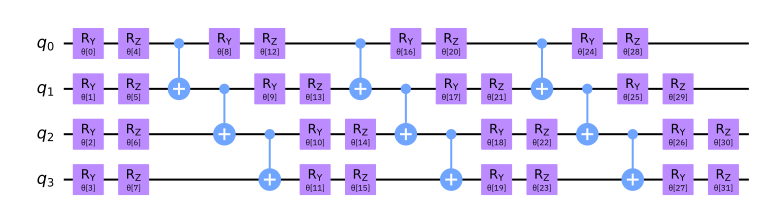

full entanglement:


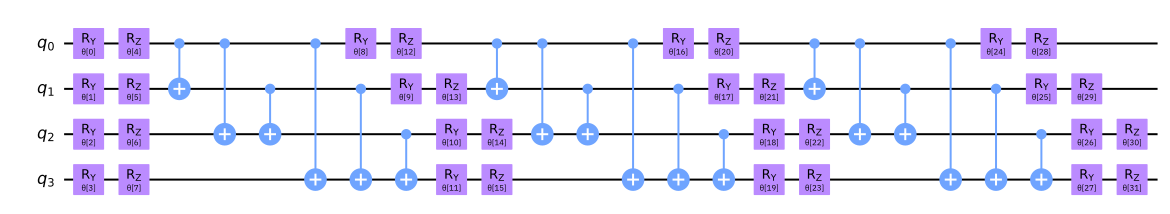

In [5]:
from qiskit.circuit.library import EfficientSU2
entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    print(f"{entanglement} entanglement:")
    # Inicializamos todos los parámetros a 0 para esta demostración.
    display(form.decompose().draw(fold=-1))

Supón que la configuración de profundidad está configurada en $d$. Entonces, RyRz tiene $2n\times (d+1)$ parámetros y Ry (no se muestra) tiene $n\times (d+1)$ parámetros.

## Implementación de VQE en Qiskit

Esta sección ilustra una implementación de VQE utilizando el enfoque programático. Qiskit Aqua también permite una implementación declarativa, sin embargo, revela menos información sobre el algoritmo subyacente. Este código, específicamente la preparación de operadores qubit, se basa en el código que se encuentra en el repositorio de tutoriales de Qiskit (y a partir de julio de 2019, se puede encontrar en: https://github.com/Qiskit/qiskit-tutorials).

Primero se deben importar las siguientes bibliotecas.


In [6]:
# pylint: disable=line-too-long
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
# pylint: enable=line-too-long

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

/var/folders/z_/6s4ntyps5lsb232v7f82201r0000gn/T/ipykernel_22101/2068492128.py:22: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation import CompleteMeasFitter


### Ejecución de VQE en un Simulador de Vector de Estado

Demostramos el cálculo de la energía del estado fundamental para LiH a varias distancias interatómicas. Se debe crear un controlador (driver) para la molécula en cada una de esas distancias. Ten en cuenta que en este experimento, para reducir la cantidad de qubits utilizados, congelamos el núcleo y eliminamos dos orbitales desocupados. Primero, definimos una función que toma una distancia interatómica y devuelve el operador qubit apropiado, $H$, así como alguna otra información sobre el operador.

In [7]:
def get_qubit_op(dist):
    # Definir la Molécula
    molecule = Molecule(
        # Coordenadas en Angstroms
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Obtener propiedades
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Definir el problema, usar la aproximación del núcleo congelado, eliminar los orbitales.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True,
                               remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Obtener el 2o Operador Cuantizado
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Establecer el Mapeador
    hamiltonian = second_q_ops[0]  # Establecer el Hamiltoniano
    # Hacer una reducción de dos qubits
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

Primero, la energía exacta del estado fundamental se calcula utilizando el operador de qubit y un solucionador propio exacto clásico. Posteriormente, se crea el estado inicial $|\psi\rangle$, que la instancia de VQE utiliza para producir el ansatz final $\min_{\theta}(|\psi(\theta)\rangle)$. Se almacena el resultado exacto y el resultado del VQE para cada distancia interatómica. Observa que el resultado dado por `vqe.run(backend)['energy'] + shift` es equivalente a la cantidad $\min_{\theta}\left(\langle \psi(\theta)|H|\psi(\theta)\rangle\right)$, donde el mínimo no es necesariamente el mínimo global.

Al inicializar la instancia de VQE con `VQE(qubit_op, var_form, optimizer, 'matrix')`, el valor esperado de $H$ en $|\psi(\theta)\rangle$ se calcula directamente a través de la multiplicación de matrices. Sin embargo, cuando se usa un dispositivo cuántico real o un verdadero simulador como `qasm_simulator` con `VQE(qubit_op, var_form, optimizer, 'paulis')`, el cálculo del valor esperado es más complicado Un Hamiltoniano se puede representar como una suma de cadenas de Pauli, con cada término de Pauli actuando en un qubit según lo especificado por el mapeo que se utiliza. Cada cadena de Pauli tiene un circuito correspondiente adjunto al circuito que corresponde a $|\psi(\theta)\rangle$. Posteriormente, cada uno de estos circuitos se ejecuta y todos los resultados se utilizan para determinar el valor esperado de $H$ en $|\psi(\theta)\rangle$. En el siguiente ejemplo, inicializamos la instancia de VQE con el modo `matrix`, por lo que el valor esperado se calcula directamente a través de la multiplicación de matrices.

Ten en cuenta que el siguiente fragmento de código puede tardar unos minutos en ejecutarse hasta completarse. 

In [8]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.04751 Exact Energy: -7.04791
Interatomic Distance: 0.7 VQE Result: -7.50392 Exact Energy: -7.50400
Interatomic Distance: 0.9 VQE Result: -7.72278 Exact Energy: -7.72283
Interatomic Distance: 1.1 VQE Result: -7.82516 Exact Energy: -7.82520
Interatomic Distance: 1.3 VQE Result: -7.86886 Exact Energy: -7.86890
Interatomic Distance: 1.5 VQE Result: -7.88210 Exact Energy: -7.88214
Interatomic Distance: 1.7 VQE Result: -7.87917 Exact Energy: -7.87920
Interatomic Distance: 1.9 VQE Result: -7.86788 Exact Energy: -7.86799
Interatomic Distance: 2.1 VQE Result: -7.85312 Exact Energy: -7.85320
Interatomic Distance: 2.3 VQE Result: -7.83763 Exact Energy: -7.83772
Interatomic Distance: 2.5 VQE Result: -7.82324 Exact Energy: -7.82343
Interatomic Distance: 2.7 VQE Result: -7.81116 Exact Energy: -7.81142
Interatomic Distance: 2.9 VQE Result: -7.80195 Exact Energy: -7.80215
Interatomic Distance: 3.1 VQE Result: -7.79516 Exact Energy: -7.79545
Interatomic Distance

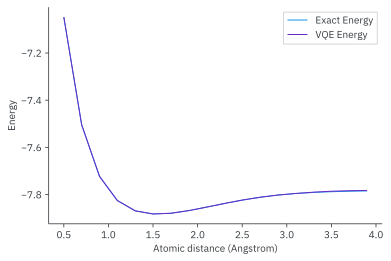

In [9]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

Observa que los resultados de VQE están muy cerca de los resultados exactos y, por lo tanto, la curva de VQE oculta la curva de la energía exacta.

### Ejecución de VQE en un Simulador Ruidoso

Aquí, calculamos la energía del estado fundamental para H$_2$ usando un simulador ruidoso y mitigación de errores.

Primero, preparamos el operador de qubit que representa el Hamiltoniano de la molécula:

In [10]:
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, -0.3625]],
              ["H", [0.0, 0.0, 0.3625]]],
    multiplicity=1,charge=0)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF)

problem = ElectronicStructureProblem(driver)

second_q_ops = problem.second_q_ops()  # Obtener el 2o Operador Cuantizado
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles

mapper = ParityMapper()  # Establecer el Mapeador

hamiltonian = second_q_ops[0]  # Establecer el Hamiltoniano

# Hacer una reducción de dos qubits
converter = QubitConverter(mapper,two_qubit_reduction=True)
reducer = TwoQubitReduction(num_particles)
qubit_op = converter.convert(hamiltonian)
qubit_op = reducer.convert(qubit_op)

Ahora, cargamos un mapa de acoplamiento de dispositivos y un modelo de ruido del proveedor IBMQ y creamos una instancia cuántica, lo que permite la mitigación de errores:

In [11]:
from qiskit.test.mock import FakeManila
from qiskit.providers.aer import QasmSimulator

backend = Aer.get_backend('aer_simulator')
device_backend = FakeManila()
device = QasmSimulator.from_backend(device_backend)
NOISE_MODEL = None
coupling_map = device.configuration().coupling_map
NOISE_MODEL = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
qi= QuantumInstance(backend,
                    coupling_map=coupling_map,
                    noise_model=NOISE_MODEL,
                    measurement_error_mitigation_cls=CompleteMeasFitter)

Finalmente, debemos configurar el optimizador, la forma variacional y la instancia de VQE. A medida que los efectos del ruido aumentan conforme lo hace la profundidad del circuito de compuertas de dos qubits, usamos una forma variacional heurística (RYRZ) en lugar de UCCSD, ya que RYRZ tiene un circuito mucho menos profundo que UCCSD y usa sustancialmente menos compuertas de dos qubits.

El código siguiente puede tardar unos minutos en ejecutarse hasta completarse.

In [12]:
result = exact_solver(problem,converter)
exact_energies.append(result.total_energies)

print("Exact Result:", result.total_energies)
optimizer = SPSA(maxiter=100)
var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
vqe = VQE(var_form, optimizer=optimizer,quantum_instance=qi)
vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
print("VQE Result:", vqe_result)

Exact Result: [-0.93317257]
VQE Result: [-0.93190611]


Cuando la mitigación de ruido está habilitada, aunque el resultado no se encuentre dentro de la precisión química (definida como dentro de 0.0016 Hartrees del resultado exacto), está bastante cerca de la solución exacta. 

## Problemas

1. Se te da un Hamiltoniano $H$ con la promesa de que su estado fundamental está cerca de un estado de $n$ qubits máximamente entrelazado. Explica qué forma (o formas) variacional es probable que aprenda de manera eficiente y precisa la energía del estado fundamental de $H$. También puedes responder creando tu propia forma variacional y explicando por qué es apropiado para usar con este Hamiltoniano.
2. Calcula el número de evaluaciones de circuito realizadas por iteración de optimización, cuando se usa el optimizador COBYLA, el `qasm_simulator` con 1000 iteraciones y un Hamiltoniano con 60 cadenas de Pauli.
3. Utiliza VQE para estimar la energía del estado fundamental de BeH$_2$ con una distancia interatómica de $1.3$Å. Puedes reutilizar la función `get_qubit_op(dist)` reemplazando `atom="Li .0 .0 .0; H .0 .0 " + str(dist)` con `atom="Be .0 .0 .0; H .0 .0 -" + str(dist) + "; H .0 .0 " + str(dist)` e invocando la función con `get_qubit_op(1.3)`. Ten en cuenta que la eliminación de los orbitales desocupados no conserva la precisión química de esta molécula. Sin embargo, para reducir la cantidad de qubits necesarios a 6 (y, por lo tanto, permitir una simulación eficiente en la mayoría de las computadoras portátiles), la pérdida de precisión es aceptable. Si bien está más allá del alcance de este ejercicio, el lector interesado puede usar operaciones de reducción de qubits para reducir la cantidad de qubits requeridos a 7, sin perder ninguna precisión química.

## Referencias

1. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." *Nature communications* 5 (2014): 4213.
2. Griffiths, David J., and Darrell F. Schroeter. Introduction to quantum mechanics. *Cambridge University Press*, 2018.
3. Shende, Vivek V., Igor L. Markov, and Stephen S. Bullock. "Minimal universal two-qubit cnot-based circuits." arXiv preprint quant-ph/0308033 (2003).
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242.

In [13]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table

Qiskit Software,Version
qiskit-terra,0.20.2
qiskit-aer,0.9.1
qiskit-ignis,0.7.1
qiskit-ibmq-provider,0.19.1
qiskit-aqua,0.9.5
qiskit,0.36.2
qiskit-nature,0.4.1
qiskit-finance,0.3.2
qiskit-optimization,0.3.2
qiskit-machine-learning,0.4.0
